# Code for the implementation of task MNIST

### Importing libraries

In [13]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import distance
from keras.datasets import mnist
import time

### 1a) Creating NN classifier with chunksize 1000 and plot confusion matrix and print error rate

#### loading of data and declaring classes

In [14]:
class Dataset:
    def __init__(self, train_X, train_y, test_X, test_y):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
                    
        data["training"]["features"] = train_X
        data["training"]["targets"] = train_y
        data["testing"]["features"] = test_X
        data["testing"]["targets"]  = test_y
        
        self.data = data
        self.DESCR = "MNISK dataset"
        self.n_training = 60000
        self.n_testing = 10000
        self.chunk_size = 1000
        self.n_chunks = self.n_training//self.chunk_size
        self.classes_names = ['0','1','2','3','4','5','6','7','8','9']


In [15]:
# loading the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# reshape to fit for our class.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
MNIST_Dataset = Dataset(train_X, train_y, test_X, test_y)



In [16]:
def NN_predict(images_predict, n_chunks, chunk_size, train_set):
    predicted = []
    time_s = time.time()
    for image in images_predict:
        min_dict = {"indices": [], "values": []}
        for i in range(n_chunks):
            # Divide into chunks
            reduced_test_set = train_set["features"][i*chunk_size:(i+1)*chunk_size]
            distances = np.ravel(distance.cdist([image], reduced_test_set, 'euclidean'))
            # find the minimum euclidean distance from each chunk
            min_cluster_index = np.argmin(distances)
            min_global_index = i*chunk_size+min_cluster_index
            min_dict["indices"].append(min_global_index)
            min_dict["values"].append(distances[min_cluster_index])
        # find the minimum euclidean distance from all chunks
        min_dict_NN_index = np.argmin(min_dict["values"])
        NN_global_index = min_dict["indices"][min_dict_NN_index]
        predicted.append(train_set["targets"][NN_global_index])
    print(f"time for Predicting: {time.time()-time_s}")
    return predicted

In [17]:
def PlotConfusionMatrix(matrix, fileName: str):
    fig, ax = plt.subplots(figsize=(8, 8))
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, 
                                   display_labels=MNIST_Dataset.classes_names,
                                   ).plot(cmap="viridis", ax=ax)
    plt.title("NN classifier", fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"{fileName}", fontsize=18, x=0.1)
    plt.savefig(f"svg_figures/{fileName}.svg")
    plt.show()

In [18]:
def conf_matrix_test(MNIST_Dataset: Dataset):
    n_classes = 10
    data = MNIST_Dataset.data
    testing_data = data["testing"]["features"]
    # Compute the prediction
    prediction = NN_predict(testing_data, MNIST_Dataset.n_chunks, MNIST_Dataset.chunk_size, data["training"])
    # For statistics
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    n_misclassified = 0
    misclassified_examples = []
    correctly_classified_examples = []
    for i in range(len(prediction)):
        target = data["testing"]["targets"][i]
        pred = prediction[i]
        conf_matrix[target, pred] += 1 
        if target != pred and len(misclassified_examples) < 4:
            n_misclassified += 1
            misclassified_examples.append([testing_data[i], pred, target])
        elif target != pred:
            n_misclassified += 1 
        elif target == pred and len(correctly_classified_examples) < 4:
            correctly_classified_examples.append([testing_data[i], pred, target])

    error_rate = float(n_misclassified) / len(testing_data)
    return conf_matrix, error_rate, misclassified_examples, correctly_classified_examples 

In [19]:
confusion_matrix, error_rate, misclassified_examples, correctly_classified_examples = conf_matrix_test(MNIST_Dataset)
print("Error rate: " + str(error_rate))
PlotConfusionMatrix(confusion_matrix, "NN_test_set")

### 1b, c) Plot some examples

In [ ]:
def PlotExamples(examples, fileName: str):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (image, predicted, target) in enumerate(examples):
        ax = axs[i//2, i%2]
        ax.set_title(f"Classified as {predicted}, target is {target}", fontsize=18)
        ax.imshow(np.reshape(image, (28, 28)), cmap='cividis')

    fig.subplots_adjust(hspace=0.4)
    plt.savefig(f"svg_figures/{fileName}.svg")
    # using svg so that the graphics looks good in latex
    plt.show()

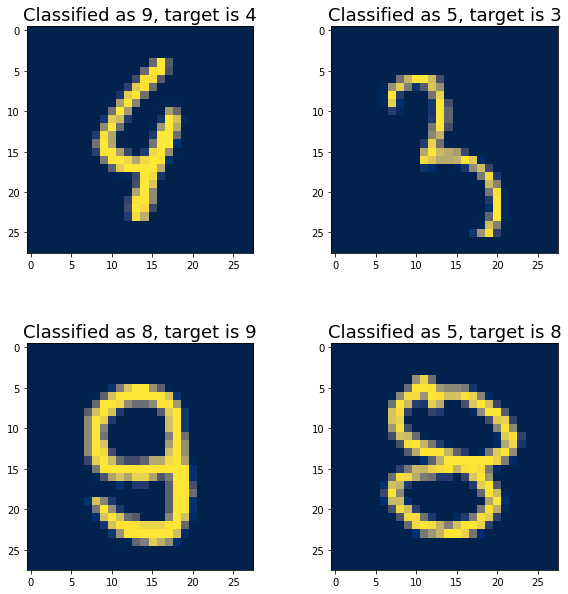

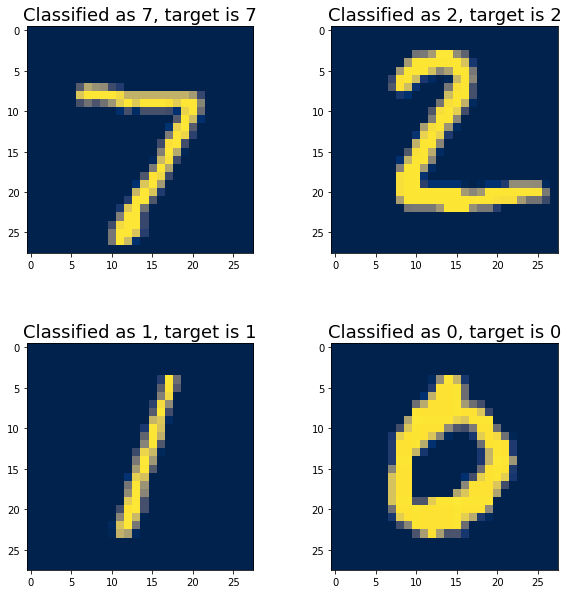

In [ ]:
PlotExamples(misclassified_examples, "misclassified")
PlotExamples(correctly_classified_examples, "Correctly_classified")

### 2a) Clustering

In [ ]:
def CreateClusters(n_clusters, train_x, train_y):
    time_s = time.time()
    # sorting the data
    n_classes = 10
    tuples = [(train_x[i], train_y[i]) for i in range(len(train_x))]
    tuples = sorted(tuples, key=lambda x: x[1])
    train_x = np.array([t[0] for t in tuples])
    train_y = np.array([t[1] for t in tuples])
    # flatten (normalize)
    train_x = train_x.flatten().reshape(train_x.shape)
    # using kmeans to create clusters 
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # trick to find the break points for when the classes change
    break_points = [0]
    for i in range(len(train_y)-1):
        if train_y[i] != train_y[i+1]:
            break_points.append(i+1)
    break_points.append(len(train_x)-1)
    
    clusters = np.empty((n_classes, n_clusters, train_x.shape[1]))
    for i in range(n_classes):
        clusters[i] = kmeans.fit(train_x[break_points[i]:break_points[i+1]]).cluster_centers_
    # clusters have all of the cluster centers for each class (64 each)
    clusters = clusters.flatten().reshape(n_classes*n_clusters, train_x.shape[1])
    print(f"time for Clustering: {time.time()-time_s}")
    return clusters

In [ ]:
def cnn_test(clusters, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    # for saving statistics
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
        # Divide index by 64 to get the class (64 cluster per class)
        pred = np.argmin(distances) // 64
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cNN_test_set")    

In [ ]:
clusters = CreateClusters(64, MNIST_Dataset.data["training"]["features"], MNIST_Dataset.data["training"]["targets"])  
cnn_test(clusters, MNIST_Dataset.data["testing"]["features"], MNIST_Dataset.data["testing"]["targets"])  

NameError: name 'MNIST_Dataset' is not defined

The performance is a little bit poorer, but the time usage is quite substantially better

### 2c) Designing a KNN classifier 

In [ ]:
def cknn_test(clusters, k, test_x, test_y):
    n_classes = 10
    test_x = test_x.flatten().reshape(test_x.shape)
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    errors = 0
    time_s2 = time.time()
    for index, img in enumerate(test_x):
        distances = []
        for cluster in clusters:
             distances.append(distance.euclidean(img, cluster))
        # Basically same as the last one but with k neighbors. Therefore we
        # need a different rule for voting
        top_k = np.argsort(distances)[:k]
        votes = [0] * n_classes
        for val in top_k:
            votes[(val // 64)] += 1
        pred = np.argmax(votes)
        conf_matrix[test_y[index], pred] += 1
        if pred != test_y[index]:
            errors += 1
    print(f"time for Predicting: {time.time()-time_s2}")
    print("Error rate: " + str(errors/len(test_y)))
    PlotConfusionMatrix(conf_matrix, "cKNN_test_set")    

time for Predicting: 37.03548526763916
Error rate: 0.065


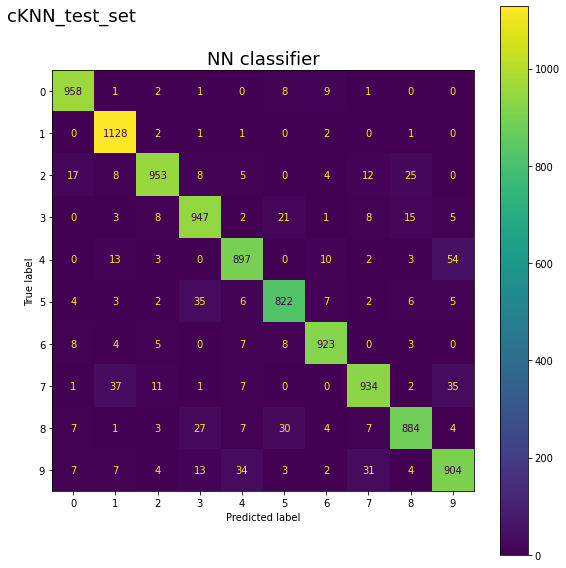

In [ ]:
cknn_test(clusters, 7, MNIST_Dataset.data["testing"]["features"], MNIST_Dataset.data["testing"]["targets"])

Once again it is a little bit poorer than the NN, but takes a lot less time.